In [2]:
import contextily as ctx
import pandas as pd
import numpy as np
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importamos el csv sobre las tarifas de uber
file_path= 'uber_fares.csv'

uber = pd.read_csv(file_path)

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [4]:
# Visualizamos las primeras 5 filas para ver los datos como son y que datos tenemos
uber.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# Visualizamos los nombre de nuestras columnas
uber.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
print(uber.isnull().sum())

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


# Valores NaN

Vemos que en la mayoria de los datos no hay valores nulos, excepto en las columnas "dropoff_longitude" y "dropoff_latitude" que tenemos 1 NaN en cada columna. Tenemos que analizar las columnas y ver si se pueden completar o es mejor eliminarlas, ya que es insignificante a la cantidad de datos que tenemos para calcular el costo del viaje.

In [8]:
#Visualizamos el/los registros que tienen los NaN
filas_nulas = uber[uber['dropoff_longitude'].isnull() | uber['dropoff_latitude'].isnull()]
print(filas_nulas)

            key                         date  fare_amount  \
87946  32736015  2013-07-02 03:51:57.0000001         24.1   

               pickup_datetime  pickup_longitude  pickup_latitude  \
87946  2013-07-02 03:51:57 UTC        -73.950581        40.779692   

       dropoff_longitude  dropoff_latitude  passenger_count  
87946                NaN               NaN                0  


Podemos checkear que la fila con indice 87946 tiene justo los 2 valores de dropoff nulos, la vamos a dejar y cuando hagamos la columna distancia lo vamos a dejar en NaN


# Datos que no sirven de la target

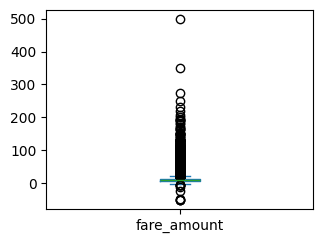

In [9]:
uber['fare_amount'].plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 15))
plt.show()

In [10]:
outliers = pd.concat([uber[uber['fare_amount'] <= 1], uber[uber['fare_amount'] >= 130]])

outliers

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
20744,25344154,2015-04-22 23:25:07.0000008,0.00,2015-04-22 23:25:07 UTC,-73.658897,40.805199,-73.658897,40.805199,1
21658,46896458,2015-05-31 16:13:41.0000001,0.01,2015-05-31 16:13:41 UTC,-73.991692,40.770802,-73.991692,40.770824,1
22182,22994576,2010-03-20 02:59:51.0000002,0.00,2010-03-20 02:59:51 UTC,-73.994366,40.755395,-73.998718,40.854853,2
63395,30260042,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,51325304,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
...,...,...,...,...,...,...,...,...,...
185325,20013003,2013-04-19 00:00:00.000000235,275.00,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.000000,1
188234,21519159,2012-08-17 12:36:08.0000002,165.00,2012-08-17 12:36:08 UTC,-73.219710,40.803600,-73.219702,40.803599,1
194454,34209729,2013-11-22 13:07:00.000000103,130.25,2013-11-22 13:07:00 UTC,-73.982272,40.763447,-74.177182,40.695032,1
196647,13085828,2010-08-19 16:52:45.0000003,200.00,2010-08-19 16:52:45 UTC,-73.952994,40.736298,-73.952994,40.736298,1


In [11]:
count_before = len(uber)
uber = uber[(uber['fare_amount'] >= 1) & (uber['fare_amount'] < 130)]
count_after = len(uber)
removed_count = count_before - count_after
print(f"Se removieron {removed_count} registros")

Se removieron 64 registros


Eliminamos 64 registros con valores negativos y menores a 1 dólar de la Target.

Establecemos ese valor como base, ya que consideramos que los valores muy cercanos a 0 y los negativos son ilógicos en un viaje de Uber y, por tanto, no nos estarían aportando nada a nuestra finalidad de predicción.


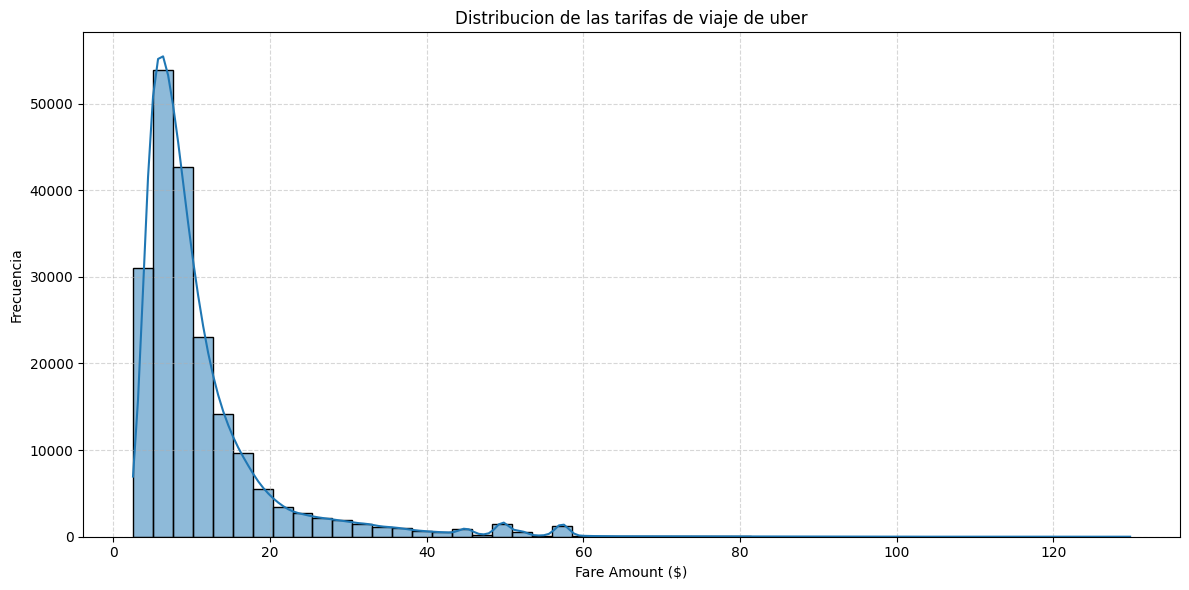

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(uber['fare_amount'], bins=50, kde=True)
plt.title('Distribucion de las tarifas de viaje de uber')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Podemos ver que la mayor frecuencia de viajes son de precios bajos.


# Analisis de las variables

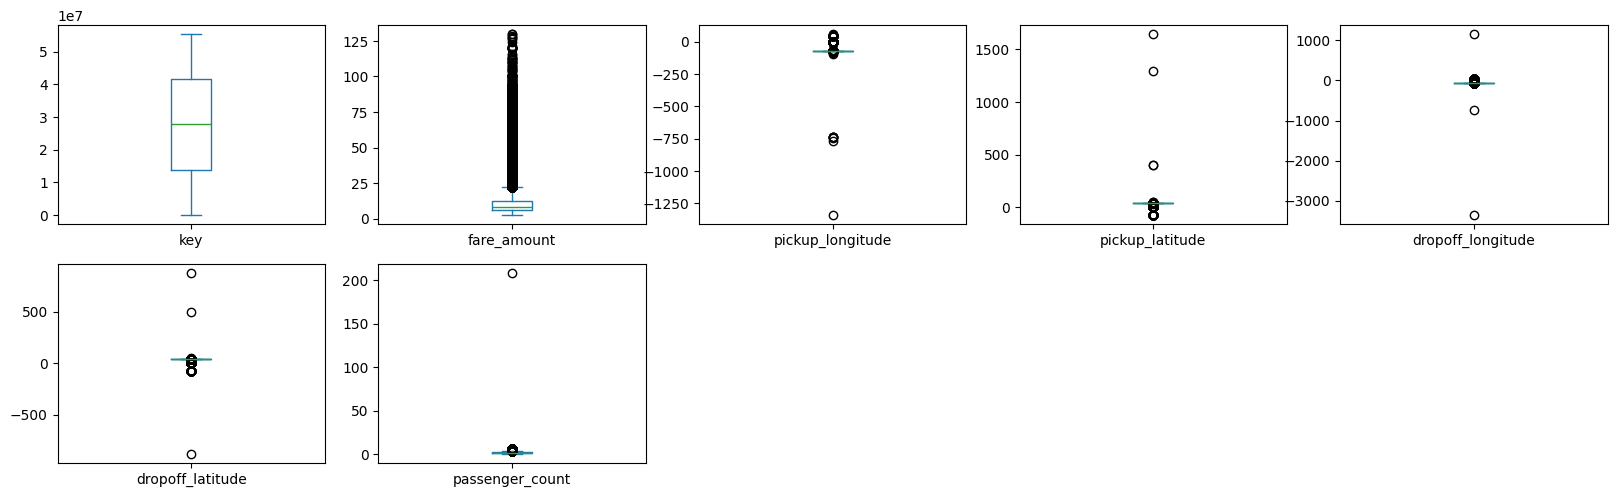

In [13]:
uber.plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 15))
plt.show()

Estuvimos analizando y determinamos que la longitud tiene un rango de -180 a 180 y la latitud de -90 a 90, por lo que los registros que están fuera de estos rangos no son valores reales de la vida, ya que no nos sirven para la predicción. Como no hay forma de determinar un valor coherente para estos valores, debemos borrarlos.

Estuvimos investigando y las coordenadas corresponden casi en su gran mayoría a Nueva York y sus alrededores, por lo que vimos las coordenadas de esta ciudad y nos dimos cuenta de que su latitud está alrededor de 40.49 a 40.92 y su longitud de -74.26 a -73.70 aproximadamente, por lo que estos van a ser los rangos de longitud y latitud que nos van a interesar para poder predecir el precio de los viajes dentro de la ciudad. Por otro lado, los registros de otras ciudades no nos interesan, al igual que los viajes a otras ciudades distintas de Nueva York o viceversa. Por lo tanto, vamos a eliminar estos datos.

Con el boxplot también analizamos que tenemos valores en 0 en la latitud y longitud de origen y destino, por lo que los tomamos como datos que no existen (NaN).

La variable de destino es «fare_amount», que calcula el precio de los viajes. Nosotros estamos usando un modelo de aprendizaje supervisado, por lo que nos interesa la etiqueta del registro. Si no la tenemos, ese registro no nos sirve para entrenar el modelo, por lo que debemos eliminarlo. En el boxplot, podemos observar valores negativos que no podrían ser reales y, por otro lado, valores en 0 o muy cercanos a 0, que tampoco nos dan una información representativa para entrenar o probar el modelo. Vamos a tomar el precio de 1 dólar como valor más bajo de la variable de respuesta.

La variable «passenger_count» tiene un solo valor atípico que modificaremos cuando dividamos el conjunto de datos y lo imputemos por la media, la mediana o la moda, para analizarlo mejor posteriormente.

También vemos que en la variable «distancia_km» se concentran los valores muy cercanos a 0, por lo que los analizaremos después de eliminar los valores que no corresponden a Nueva York o que son menores o iguales a 0.


# Datos sin latitud o longitud irreales

In [14]:
uber[((uber["pickup_longitude"]>=-180) & (uber["pickup_longitude"]<=180)) & ((uber["pickup_latitude"]>=-90) & (uber["pickup_latitude"]<=90))
               &
              ((uber["dropoff_longitude"]>=-180) & (uber["dropoff_longitude"]<=180)) & ((uber["dropoff_latitude"]>=-90) & (uber["dropoff_latitude"]<=90))]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


En el presente análisis, se evidencia que el número de registros totales es de 199 987, lo que sugiere la presencia de 13 registros que no se ajustan al rango establecido para las variables de longitud y latitud tanto en el origen como en el destino.

# Datos de latitud o longitud pertenecientes a la ciudad de Nueva York

In [15]:
uber_filtrado = uber[((uber["pickup_longitude"]>=-74.26) & (uber["pickup_longitude"]<=-73.70)) & ((uber["pickup_latitude"]>=40.49) & (uber["pickup_latitude"]<=40.92))
               &
              ((uber["dropoff_longitude"]>=-74.26) & (uber["dropoff_longitude"]<=-73.70)) & ((uber["dropoff_latitude"]>=40.49) & (uber["dropoff_latitude"]<=40.92))]

In [16]:
uber_filtrado

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


Se procede a la obtención de 195 499 registros, de los cuales 4473 no corresponden a la ciudad de Nueva York.

Estos registros fueron eliminados debido a su inconsistencia con el problema de interés, que es la predicción del valor de los viajes realizados a través de la plataforma Uber en la ciudad de Nueva York.

In [17]:
# Creamos una funcion para calcular la distancias en KM de los viajes
def haversine_distancia(lon1, lat1, lon2, lat2):
    lon1_r, lat1_r, lon2_r, lat2_r = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2_r - lon1_r
    dlat = lat2_r - lat1_r
    a = np.sin(dlat/2)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

uber_filtrado['distancia_km'] = haversine_distancia(
    uber['pickup_longitude'],
    uber['pickup_latitude'],
    uber['dropoff_longitude'],
    uber['dropoff_latitude']
)

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/705743866.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['distancia_km'] = haversine_distancia(


Una vez obtenidas las variables de latitud y longitud tanto de origen como de destino, es posible calcular la distancia recorrida durante el viaje. Este cálculo se almacena en la columna denominada «distancia_km». Para ello, se utiliza la fórmula de Haversine, que requiere convertir las coordenadas de latitud y longitud expresadas en grados a radianes. Posteriormente, se calculan los delta, que representan la diferencia entre las longitudes y latitudes del origen y el destino. Una vez obtenidos los delta, se aplica la fórmula de Haversine utilizando el radio de la Tierra como factor de curvatura terrestre, a pesar de que las distancias involucradas son insignificantes.


In [18]:
plo = uber_filtrado[uber_filtrado['pickup_longitude']==0 ].count()
pla = uber_filtrado[uber_filtrado['pickup_latitude']==0 ].count()
dlo = uber_filtrado[uber_filtrado['dropoff_longitude']==0 ].count()
dla = uber_filtrado[uber_filtrado['dropoff_latitude']==0 ].count()
print (plo + pla + dlo + dla)

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distancia_km         0
dtype: int64


Como se evidencia en el análisis de los datos, aquellos que presentan una latitud y una longitud de origen o destino de 0 han sido descartados.

Min distance: 0.00 km
Max distance: 35.34 km
Mean distance: 3.31 km
Median distance: 2.16 km


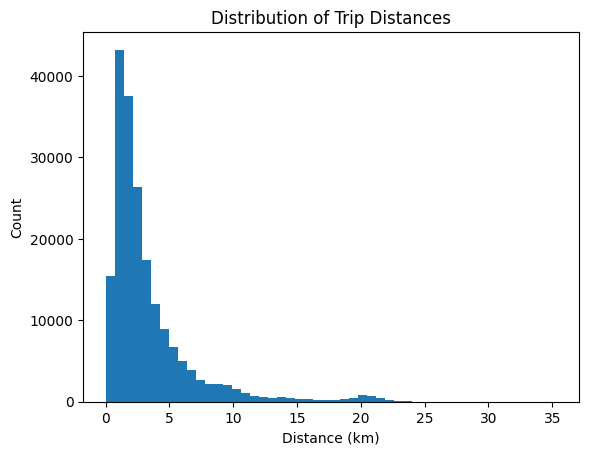

In [19]:
print(f"Min distance: {uber_filtrado.distancia_km.min():.2f} km")
print(f"Max distance: {uber_filtrado.distancia_km.max():.2f} km")
print(f"Mean distance: {uber_filtrado.distancia_km.mean():.2f} km")
print(f"Median distance: {uber_filtrado.distancia_km.median():.2f} km")

plt.hist(uber_filtrado.distancia_km, bins=50)
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()

Vemos que nuestro rango de distancia está entre 0 km y un poco más de 35 km, lo que es muy coherente, porque son pocos los trayectos que superan esta distancia, pero pueden ser reales. La gráfica está sesgada hacia la derecha, con valores más pequeños que grandes, pero tiene sentido, ya que como la demanda de viajes se concentra en Manhattan, se realizan más los recorridos cortos y de poca distancia. El promedio de distancia de los viajes es de 3,44 km.

Por otro lado, como no podemos tener distancia 0, vamos a poner un nan a los valores menores de 0,3 km, entendiendo que lo menos que se recorrió fueron 3 cuadras.

Podemos ver tomando en cuenta la grafica de frecuencia de la target que se comporta muy paresida, seguro porque el precio con la cantidad de km estan bastante correlacionados.

In [20]:
uber_filtrado[uber_filtrado['distancia_km']<0.3]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_km
5,44470845,2011-02-12 02:27:09.0000006,4.90,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,0.000000
48,22405517,2013-01-03 22:24:41.0000002,56.80,2013-01-03 22:24:41 UTC,-73.993498,40.764686,-73.993498,40.764686,1,0.000000
84,25485719,2009-08-07 10:43:07.0000001,49.57,2009-08-07 10:43:07 UTC,-73.975058,40.788820,-73.975058,40.788820,1,0.000000
166,54642873,2014-01-22 21:01:18.0000004,4.50,2014-01-22 21:01:18 UTC,-73.992937,40.757780,-73.992937,40.757780,1,0.000000
207,49651743,2009-03-24 23:06:00.000000173,3.70,2009-03-24 23:06:00 UTC,-73.974302,40.761193,-73.971943,40.759643,5,0.263023
...,...,...,...,...,...,...,...,...,...,...
199675,14327992,2012-01-27 16:36:00.000000180,53.30,2012-01-27 16:36:00 UTC,-73.953060,40.774205,-73.951238,40.773545,5,0.170074
199917,45368488,2013-06-24 22:17:43.0000002,4.50,2013-06-24 22:17:43 UTC,-73.793768,40.656939,-73.793768,40.656939,1,0.000000
199932,46517645,2011-03-22 13:59:00.00000018,24.90,2011-03-22 13:59:00 UTC,-73.974618,40.756295,-73.974618,40.756295,5,0.000000
199988,40002753,2011-10-09 02:02:40.0000001,3.70,2011-10-09 02:02:40 UTC,-73.988674,40.739342,-73.990730,40.738980,1,0.177836


Como podemos ver, son 4547 registros cuyo valor es menor de 0,3 km, por lo que vamos a cambiar su contenido a nan.

In [21]:
uber_filtrado.loc[uber_filtrado['distancia_km'] < 0.3, 'distancia_km'] = np.nan

In [22]:
uber_filtrado['distancia_km'].isna().value_counts()

distancia_km
False    190952
True       4547
Name: count, dtype: int64

# Analisis de datos que quedaron

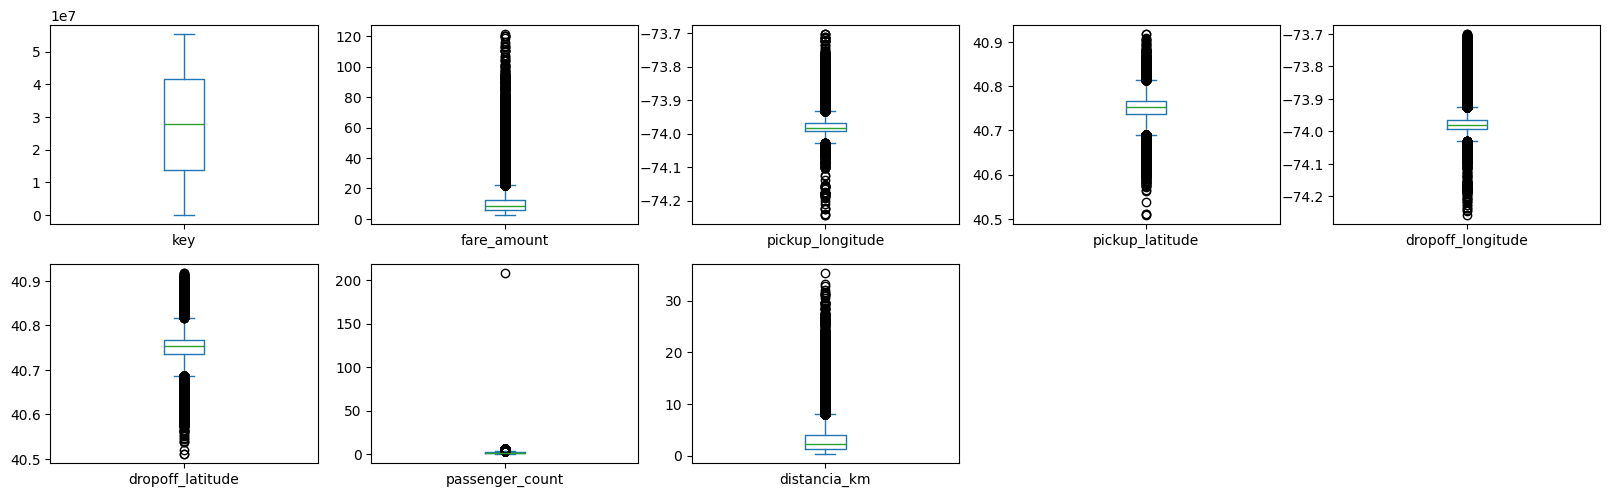

In [23]:
uber_filtrado.plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 15))
plt.show()

El análisis muestra distribuciones de variables claves:

- Coordenadas geográficas: Las latitudes y longitudes (pickup/dropoff) tienen distribuciones concentradas en rangos específicos (lat: 40.5-40.9, long: -74.2 a -73.7), lo que indica que los viajes son de corta distancia, en su mayoria y lo podemos confirmar con la variable "distancia_km" la cual vemos que estan hasta 10 la gran mayoria.

- Distancia_km: La mayoría de viajes son cortos, aunque hay outliers que alcanzan más de 30km.

- Fare_amount: Estan principalmente entre 0 y 20 dolares, aunque hay valores atípicos superiores a 100 dolares, que no lo son son precios de viajes correctos pero con menos frecuencia.

- Passenger_count: la gran mayoria estan muy cercano a 0, teniendo un outliers superior a los 200

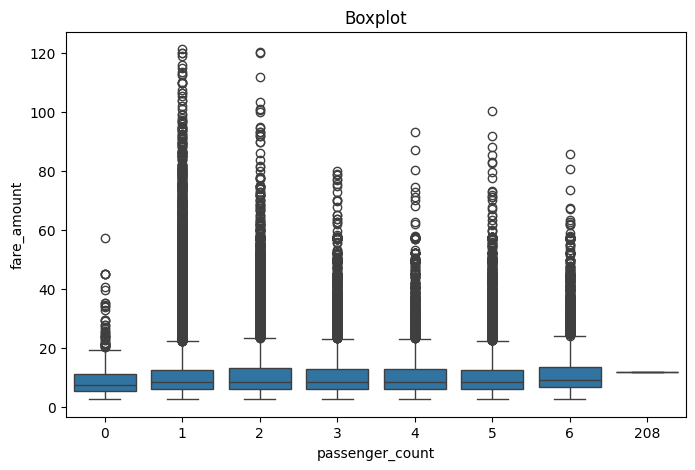

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=uber_filtrado['passenger_count'], y=uber_filtrado['fare_amount'])
plt.title(f'Boxplot')
plt.show()

vemos que para cada cantidad de pasajeros, entre 1 y 2 son la mayoria de variacion del precio, tambien porque son con la cantidad de pasajeros que se hicieron mas viajes. Pero luego observamos que todos los viajes estan concentrados en un mismo valor promedio, viendo que la mediana del boxplot no se desplazan en comparacion de los demas.

luego tenemos un valor de 208 que seguramente es un valor atipico el cual es erroneo porque no puede tener 208 pasajeros en vehiculo, nio siquiera un colectivo por si se quisiera justificar de alguna forma. Por lo que vamos a eliminar el comtenido de la columna y dejarlo en Nan.

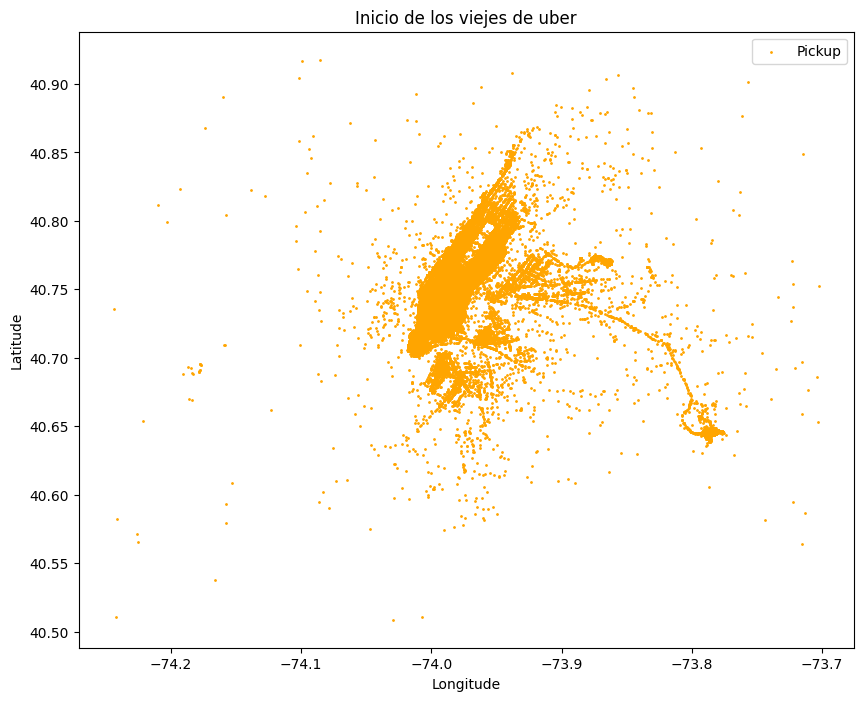

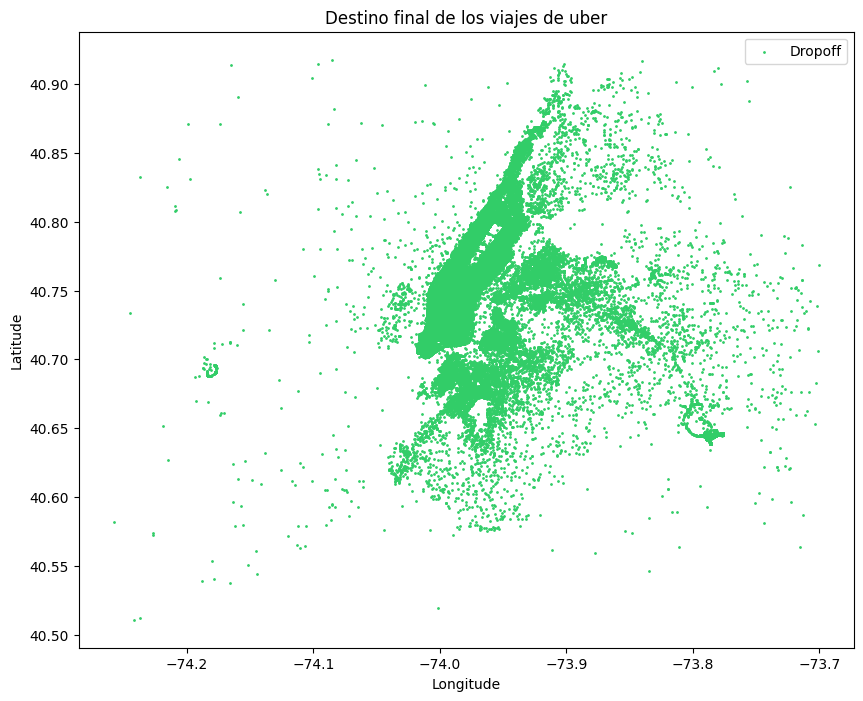

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(uber_filtrado['pickup_longitude'], uber_filtrado['pickup_latitude'], s=1, label='Pickup', color= '#FFA500')
plt.legend()
plt.title('Inicio de los viejes de uber')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


plt.figure(figsize=(10, 8))
plt.scatter(uber_filtrado['dropoff_longitude'], uber_filtrado['dropoff_latitude'], s=1, label='Dropoff', color='#32cd68')
plt.legend()
plt.title('Destino final de los viajes de uber')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

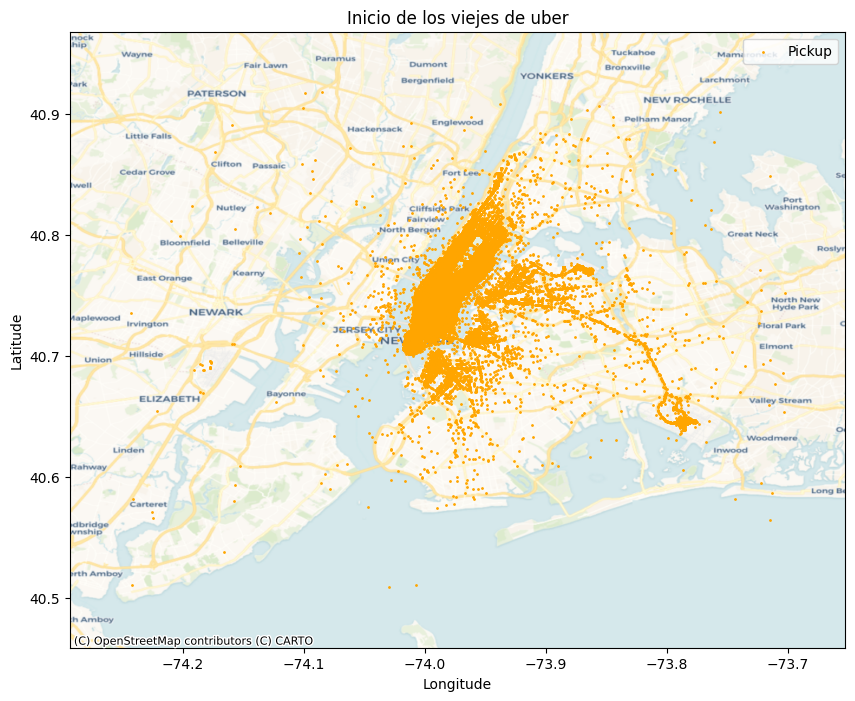

In [26]:
plt.figure(figsize=(10, 8))
ax = plt.gca()  # Obtener el eje actual

# Graficar los puntos de destino
ax.scatter(uber_filtrado['pickup_longitude'], uber_filtrado['pickup_latitude'], s=1, label='Pickup', color='#FFA500')

# Agregar el mapa de fondo
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager) #EPSG:4326 es el sistema de coordenadas de longitud y latitud

# Ajustar los límites del gráfico para que coincidan con los datos
ax.set_xlim(uber_filtrado['pickup_longitude'].min() - 0.05, uber_filtrado['pickup_longitude'].max() + 0.05)
ax.set_ylim(uber_filtrado['pickup_latitude'].min() - 0.05, uber_filtrado['pickup_latitude'].max() + 0.05)

plt.legend()
plt.title('Inicio de los viejes de uber')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

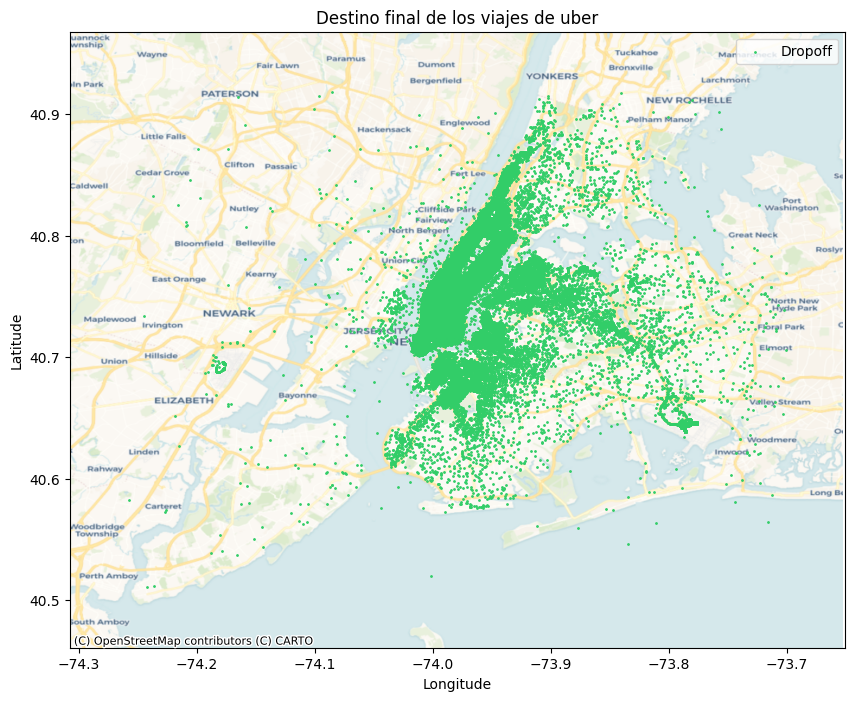

In [27]:
plt.figure(figsize=(10, 8))
ax = plt.gca()  # Obtener el eje actual

# Graficar los puntos de destino
ax.scatter(uber_filtrado['dropoff_longitude'], uber_filtrado['dropoff_latitude'], s=1, label='Dropoff', color='#32cd68')

# Agregar el mapa de fondo
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Voyager) #EPSG:4326 es el sistema de coordenadas de longitud y latitud

# Ajustar los límites del gráfico para que coincidan con los datos
ax.set_xlim(uber_filtrado['dropoff_longitude'].min() - 0.05, uber_filtrado['dropoff_longitude'].max() + 0.05)
ax.set_ylim(uber_filtrado['dropoff_latitude'].min() - 0.05, uber_filtrado['dropoff_latitude'].max() + 0.05)

plt.legend()
plt.title('Destino final de los viajes de uber')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

La mayoría de los puntos de inicio y final de los viajes son principalmente en Manhattan, que es la zona de la ciudad más concurrida por los turistas, por lo que es probable que el consumo de Uber sea mayor en ese lugar. Sin embargo, observamos una ligera diferencia: el inicio del viaje es en Manhattan, pero el destino es la zona limítrofe con Queens y Brooklyn.

# Desglose de variable tiempo

Tenemos dos variables, date y pickup_datetime, que a simple vista parecen iguales, solo que una está en UTC. De todos modos, las compararemos para verificar si las dos columnas de cada fila siempre coinciden.

In [28]:
# Cambiamos las 2 variables para que las tome como date y no un string
uber_filtrado['date'] = pd.to_datetime(uber_filtrado['date'])
uber_filtrado['pickup_datetime'] = pd.to_datetime(uber_filtrado['pickup_datetime'])
uber_filtrado["date"] = uber_filtrado["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
uber_filtrado["pickup_datetime"] = uber_filtrado["pickup_datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")


/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/906457954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['date'] = pd.to_datetime(uber_filtrado['date'])
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/906457954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['pickup_datetime'] = pd.to_datetime(uber_filtrado['pickup_datetime'])
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/906457954.py:4: SettingWithCopyWarning: 
A valu

In [29]:
contador = 0
date_tof = uber_filtrado['pickup_datetime'] == uber_filtrado['date']

date_tof.value_counts()

True    195499
Name: count, dtype: int64

Como podemos confirmar que las dos columnas son iguales, vamos a utilizar «pickup_datetime».

In [30]:
uber_filtrado['pickup_datetime'] = pd.to_datetime(uber_filtrado['pickup_datetime'])
# Vamos a tratar las variables de tiempo para ver bien el tema de los dias, horas, etc. Ya que ciertos dias a cierta hora el viaje puede tener mayor demanda y por ende mayor costo
uber_filtrado['hora'] = uber_filtrado['pickup_datetime'].dt.hour
# esta ffuncion tomo el 0 como LUNES hasta el 6 que es DOMINGO
uber_filtrado['dia_semana'] = uber_filtrado['pickup_datetime'].dt.dayofweek
uber_filtrado['mes'] = uber_filtrado['pickup_datetime'].dt.month
uber_filtrado['minutos'] = uber_filtrado['pickup_datetime'].dt.minute
uber_filtrado['dia'] = uber_filtrado['pickup_datetime'].dt.day
uber_filtrado['año'] = uber_filtrado['pickup_datetime'].dt.year

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/3897661672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['pickup_datetime'] = pd.to_datetime(uber_filtrado['pickup_datetime'])
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/3897661672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['hora'] = uber_filtrado['pickup_datetime'].dt.hour
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/3897661672.py:5: SettingWithCopyWarning: 


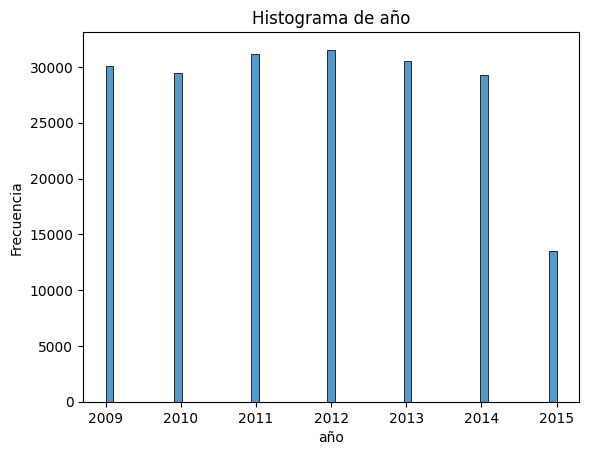

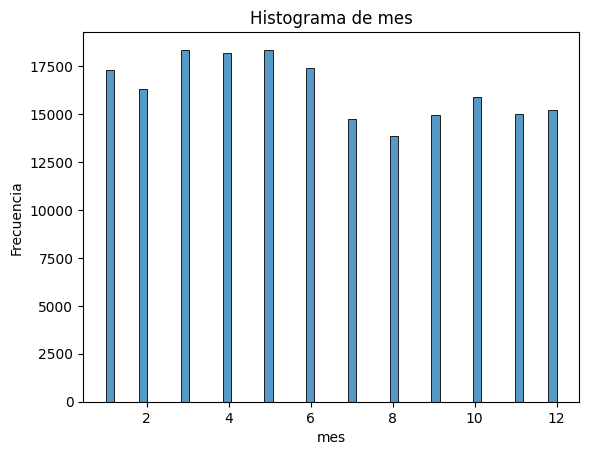

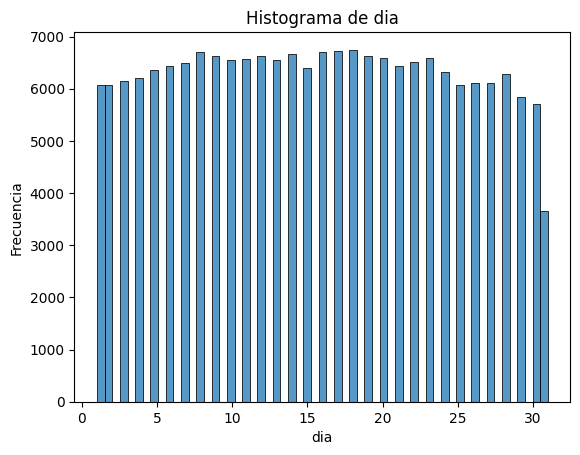

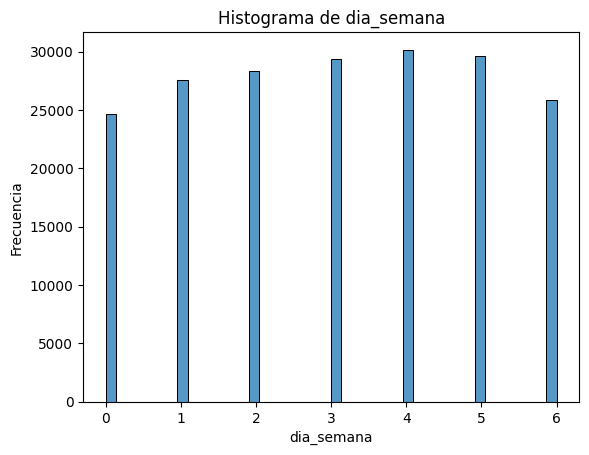

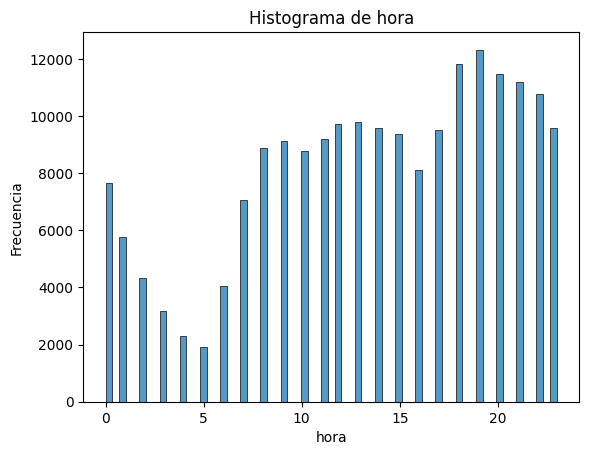

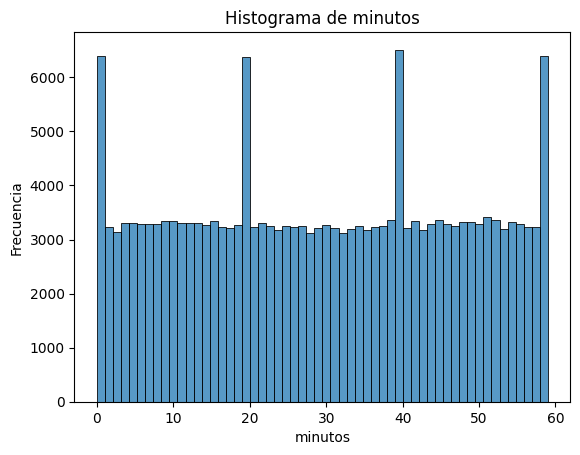

In [31]:
for col in ['año', 'mes', 'dia', 'dia_semana', 'hora', 'minutos']:
    sns.histplot(uber_filtrado[col])
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

Tenemos las distribuciones de cada parte del tiempo, y lo que más termina aportando es la hora, el día de la semana y los días del mes.

En el año podemos ver que es bastante constante, menos en 2015, seguramente porque debemos tener menos datos de ese año. También son datos que no se van a repetir, porque se van a ir incrementando año a año. Tampoco queremos hacer predicciones anuales, sino diarias.

No utilizaremos el mes porque necesitamos predecir el precio diariamente y no mensualmente. Aunque vemos que los primeros meses tienen más viajes, esto se debe a la falta de registros de 2015, que es el único año que no tiene registros completos, por lo que la primera parte del año tiene más viajes.

El día también es bastante constante, aunque vemos que los valores medios son los días en que más se consume Uber. Al principio y al final del mes, el consumo es menor, pero puede coincidir con los días de cobro de los sueldos, cuando aumenta el consumo de Uber y se realizan viajes de turismo. El día 31 es el que menos tiene porque no todos los meses tienen 31 días.

La hora es sumamente importante, porque podemos observar cómo va variando el consumo a lo largo del día y ver que en la madrugada se consume menos y va en aumento hasta llegar a la noche, que es cuando se realizan la mayor cantidad de viajes.

Los minutos no son importantes, ya que la distribución es constante y se salta cada 15 minutos. Sin embargo, la usaremos para ver si la hora está más cerca de la siguiente, porque si son las 9:58, ya son más las 10 que las 9 de la mañana, por ejemplo.


Nos quedamos con el día de la semana, ya que nos importa y modifica el consumo, que es máximo en el fin de semana, por lo que vamos a dividir en dos: si es fin de semana o día de semana.


In [32]:
# si tenemos un numero que es mas que las y media tomamos como hora, la hora siguiente
uber_filtrado['hora'] = uber_filtrado['minutos'].apply(lambda x: x+1 if x >= 30 else x+0 )

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/1282495878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['hora'] = uber_filtrado['minutos'].apply(lambda x: x+1 if x >= 30 else x+0 )


In [33]:
# Hacemos la divicion de la columna dia_semana porque asi reducimos la dimencionalidad del modelo
uber_filtrado['finde'] = uber_filtrado['dia_semana'].apply(lambda x: 0 if x < 4  else 1)

# Hacemos 3 columnas las cuales nos muestra las 4 semanas del mes, la semana 4 es cuando las 3 anteriores son 0
uber_filtrado['semana1'] = uber_filtrado['dia'].apply(lambda x: 1 if x > 0 and x < 8 else 0 )
uber_filtrado['semana2'] = uber_filtrado['dia'].apply(lambda x: 1 if x > 7 and x < 16 else 0 )
uber_filtrado['semana3'] = uber_filtrado['dia'].apply(lambda x: 1 if x > 15 and x <23  else 0 )

# A la hora la dividimos en 4 mañana, tarde, noche y madrugada en intervalos de 6 horas cada uno. La madrugada se da cuando las otras tres variables estan en 0.
uber_filtrado['manana'] = uber_filtrado['hora'].apply(lambda x: 1 if x >= 7 and x <= 12 else 0 )
uber_filtrado['tarde'] = uber_filtrado['hora'].apply(lambda x: 1 if x >= 13 and x <= 18 else 0 )
uber_filtrado['noche'] = uber_filtrado['hora'].apply(lambda x: 1 if x >= 19 and x <= 24 else 0 )

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/1703674506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['finde'] = uber_filtrado['dia_semana'].apply(lambda x: 0 if x < 4  else 1)
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/1703674506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['semana1'] = uber_filtrado['dia'].apply(lambda x: 1 if x > 0 and x < 8 else 0 )
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/17036745

In [34]:
# cambiamos la columna date a datetime asi pandas lo puede tomar como una colmna fecha
uber_filtrado['date'] = pd.to_datetime(uber_filtrado['date'], dayfirst=False)

# Pasamos la columna date en el formato YYYY-MM-DD
uber_filtrado['date']  = uber_filtrado['date'].dt.date

# Obtener feriados de EE.UU.
us_holidays = holidays.US(years=range(2009, 2015))

# Crear una nueva columna llamada "es_feridado" a cual nos indicara con True o False si es feriado
uber_filtrado['es_feriado'] = uber_filtrado['date'].isin(us_holidays)

uber_filtrado

/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/504104019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['date'] = pd.to_datetime(uber_filtrado['date'], dayfirst=False)
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/504104019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_filtrado['date']  = uber_filtrado['date'].dt.date
/var/folders/6v/vvlsrhf9375dd2sb2m9p71mc0000gn/T/ipykernel_36485/504104019.py:11: SettingWithCopyWarning: 
A value is trying 

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_km,...,dia,año,finde,semana1,semana2,semana3,manana,tarde,noche,es_feriado
0,24238194,2015-05-07,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,...,7,2015,0,1,0,0,0,0,0,False
1,27835199,2009-07-17,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,...,17,2009,1,0,0,1,0,0,0,False
2,44984355,2009-08-24,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,...,24,2009,0,0,0,0,0,0,0,False
3,25894730,2009-06-26,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,...,26,2009,1,0,0,0,0,0,1,False
4,17610152,2014-08-28,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,...,28,2014,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,NaN,...,28,2012,1,0,0,0,0,0,0,False
199996,16382965,2014-03-14,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,1.875050,...,14,2014,1,0,1,0,1,0,0,False
199997,27804658,2009-06-29,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,12.850319,...,29,2009,0,0,0,0,0,0,0,False
199998,20259894,2015-05-20,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,3.539715,...,20,2015,0,0,0,1,0,0,0,False


Dado que es muy probable que el precio de los viajes también aumente en días feriados, se ha añadido una nueva columna con dichos días.

# Eliminamos las columnas que ya no forman parte de nuestro dataset para entrenar el modelo

La variable key es un identificador que no nos importa ni nos aporta información a la predicción, por lo que lo eliminamos.


In [35]:
# Eliminamos la key porque no nos sirve es una variable para identificar el viaje que no aporta a la prediccion del precio del fiaje sino para identificarlo.
uber_filtrado = uber_filtrado.drop('key',axis=1)
# Eliminamos la columna date y pickup_datetime porque ya no nos aporta informacion, ya que la desglosamos en cada una de sus partes.
uber_filtrado = uber_filtrado.drop(['pickup_datetime','date'],axis=1)
# Eliminamos las partes de las fechas porque ya las pusimos en variables damies para que se puedan procesar bien con el modelo que luego vamos a aplicar.
uber_filtrado = uber_filtrado.drop(['mes','minutos','dia','año','hora','dia_semana'],axis=1)
# Eliminamos la variables de longitu y latitud de origen y destino ya que tenemos la distancia que se realizo en el vieja.
uber_filtrado = uber_filtrado.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)

# División del dataset en train y test

In [36]:
#Vamos a dividir nuestro conjunto de datos en train y test, 80% en train y 20% en test, y usamos la semilla random state 42
X = uber_filtrado.drop('fare_amount', axis=1)
y = uber_filtrado['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

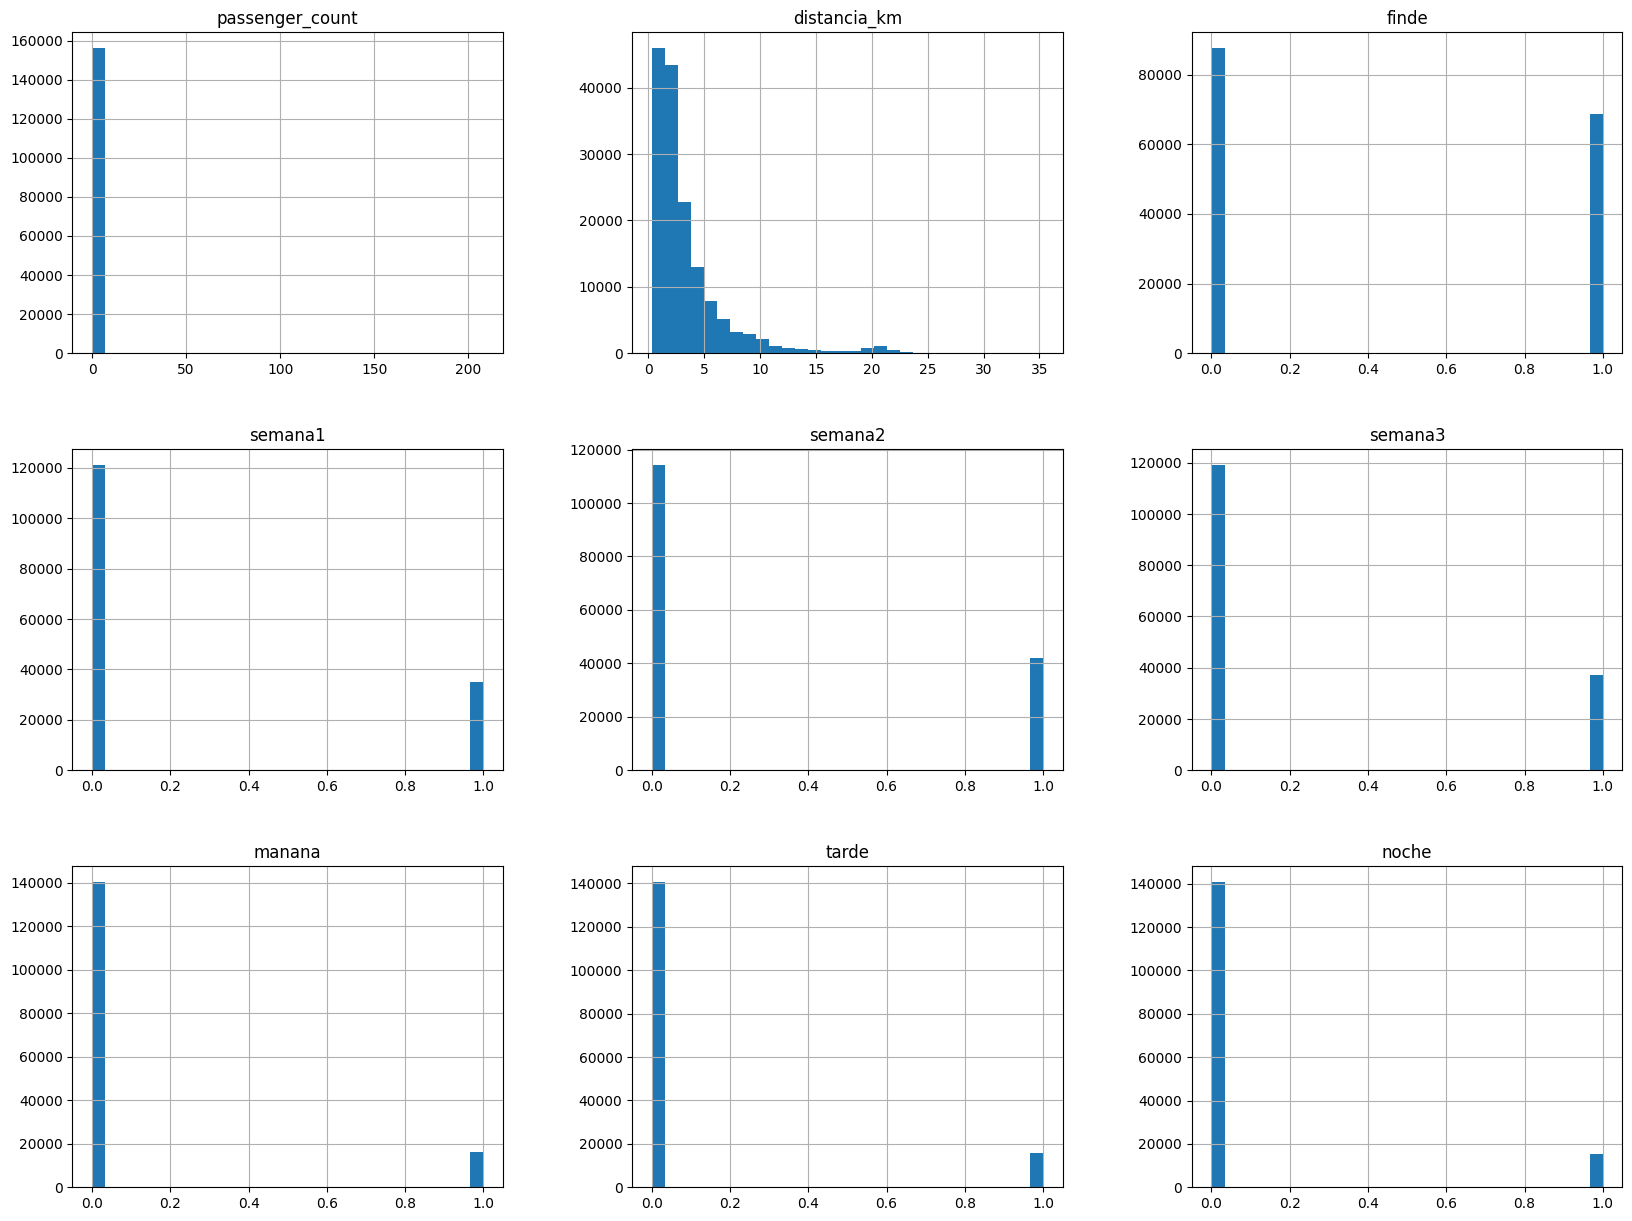

In [37]:
X_train.hist(bins=30, figsize=(20, 15))
plt.show()

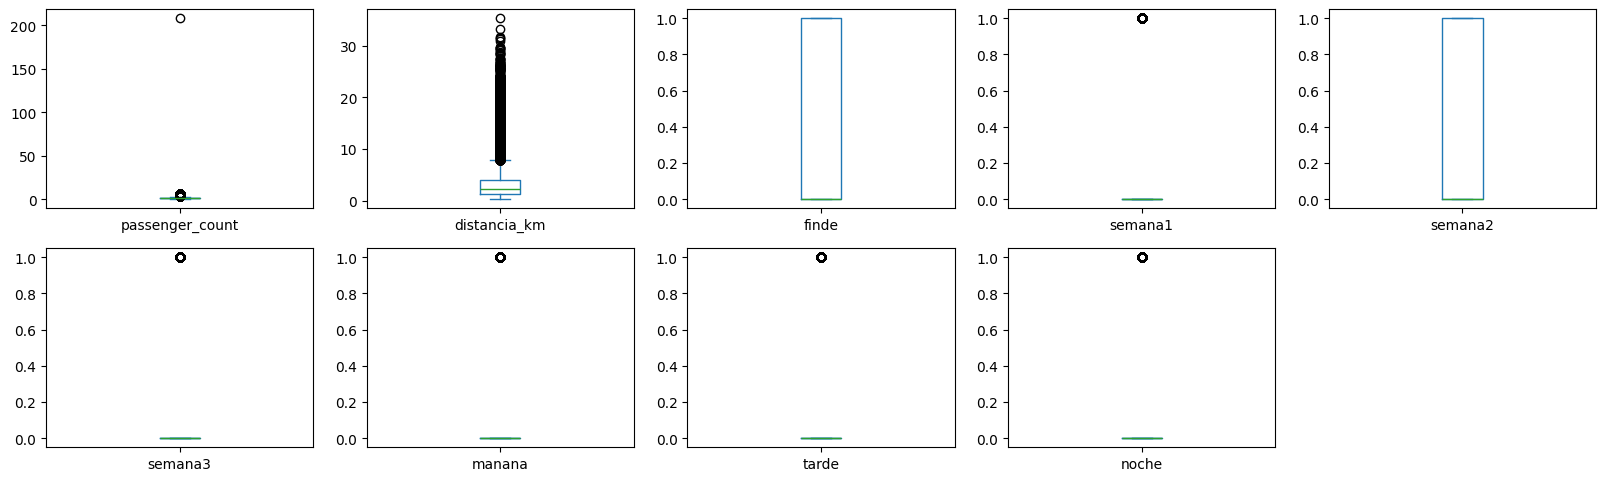

In [38]:
X_train.plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 15))
plt.show()

La distancia, por lo que vemos, está sesgada hacia la derecha, por lo que la mayoría de los viajes fueron menores de 5 km, pero tenemos valores mayores de 30 km, que son valores lógicos, por lo que no creemos que puedan ser valores atípicos o con error.

Las demás variables tienen valores 0 o 1 porque no podemos hacer mucho análisis, solo podemos observar que tenemos casi la misma cantidad de valores que los que son fin de semana que los que son semana y, después, las semanas están bastante iguales en cantidad de registros, igual que las partes del día.
La variable passenger_count muestra que todos los valores están muy cercanos a 0, pero debemos tener algún valor cercano a 200, que nos muestra hasta el registro 200 de la gráfica.


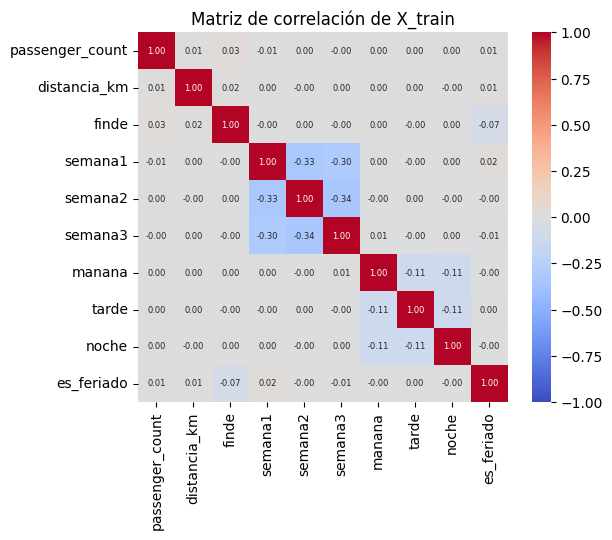

In [39]:
uber_corr = X_train.corr()

sns.heatmap(uber_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            center=0, square=True, fmt='.2f', annot_kws={'size': 6})
plt.title('Matriz de correlación de X_train')
plt.show()

No hay correlación entre la mayoría de las variables, por lo que no es necesario eliminar ninguna porque ninguna es representativa de la otra.

In [40]:
X_train.isna().value_counts()

passenger_count  distancia_km  finde  semana1  semana2  semana3  manana  tarde  noche  es_feriado
False            False         False  False    False    False    False   False  False  False         152764
                 True          False  False    False    False    False   False  False  False           3635
Name: count, dtype: int64

In [41]:
print(X_train.isna().sum())

passenger_count       0
distancia_km       3635
finde                 0
semana1               0
semana2               0
semana3               0
manana                0
tarde                 0
noche                 0
es_feriado            0
dtype: int64


Como podemos ver tenemos valores Nan en la variables "distancia_km" con una cantidad de 3199 registros.

In [42]:
mediana_distancia_km = X_train['distancia_km'].median()

X_train['distancia_km'] = X_train['distancia_km'].fillna(mediana_distancia_km)
X_test['distancia_km'] = X_test['distancia_km'].fillna(mediana_distancia_km)

print(f"Mediana usada para imputación: {mediana_distancia_km}")

Mediana usada para imputación: 2.2050223162520277


Imputamos los valores nan de la variable «distancia_km» con la mediana porque, como nuestra distribución de datos está sesgada, la mediana nos da un mejor valor que la media. Vimos que la mayoría de los valores están entre 0 y 5 km, por lo que calculamos la media.

La variable passenger_count representa la cantidad de pasajeros en el viaje, con valores que van desde 0 hasta 6.
Para mejorar la interpretación y reducir la dimensionalidad del modelo, agrupamos estos valores en tres categorías:

- Paquete (passenger_count = 0): indica que el viaje no transportó pasajeros, sino un paquete.

- Auto regular (passenger_count entre 1 y 4): Representa un viaje en un vehículo estándar con hasta cuatro pasajeros.

- Auto grande (passenger_count = 5 o 6): Se considera que requiere un vehículo de mayor capacidad.

In [43]:
# Como ya sabemos que el valor de 208 es irreal lo dejamos con un valor NaN
X_train.loc[X_train['passenger_count'] > 6, 'passenger_count'] = np.nan
X_test.loc[X_test['passenger_count'] > 6, 'passenger_count'] = np.nan

moda = X_train['passenger_count'].mode()

X_train['passenger_count'] = X_train['passenger_count'].fillna(mediana_distancia_km)
X_test['passenger_count'] = X_test['passenger_count'].fillna(mediana_distancia_km)

# A la cantidad de pasajeros la dividimos en 3, paquete, auto_regular y auto_grande. Paquete se da cuando las otras variables estan en 0
X_train['auto_regular'] = X_train['passenger_count'].apply(lambda x: 1 if 1 <= x <= 4 else (np.nan if pd.isna(x) else 0))
X_test['auto_regular'] = X_test['passenger_count'].apply(lambda x: 1 if 1 <= x <= 4 else (np.nan if pd.isna(x) else 0))

X_train['auto_grande'] = X_train['passenger_count'].apply(lambda x: 1 if x >= 5 else (np.nan if pd.isna(x) else 0))
X_test['auto_grande'] = X_test['passenger_count'].apply(lambda x: 1 if x >= 5 else (np.nan if pd.isna(x) else 0))

X_train.drop("passenger_count",axis=1)

,distancia_km,finde,semana1,semana2,semana3,manana,tarde,noche,es_feriado,auto_regular,auto_grande
163623,1.814359,1,0,1,0,0,0,0,False,1,0
168293,1.999316,0,0,0,1,0,1,0,False,1,0
85461,0.886900,0,0,0,0,0,0,1,False,0,1
171707,2.590403,0,0,1,0,0,1,0,False,1,0
72612,2.030419,1,0,0,1,0,0,0,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...
122688,9.879041,0,0,0,0,0,0,0,False,1,0
106102,0.749295,1,1,0,0,0,0,0,False,1,0
134994,0.787531,0,0,0,0,1,0,0,False,1,0
150264,0.681767,0,0,1,0,0,0,0,False,1,0


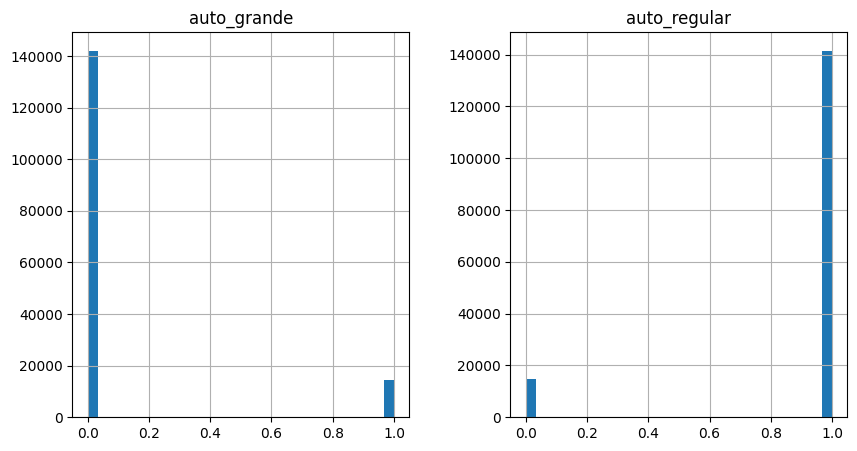

In [44]:
X_train[['auto_grande','auto_regular']].hist(bins=30, figsize=(10, 5))
plt.show()

La capacidad del vehículo está determinada por su tamaño, y al revisar los registros, se observa que la mayoría de ellos, por no decir todos, corresponden a vehículos estándar con una capacidad máxima de cuatro pasajeros. Esto implica que los vehículos grandes y los paquetes deben tener un valor total de menos de 20 000, como se evidencia en la variable «vehículo grande».

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['distancia_km']])
X_test_scaled = scaler.fit_transform(X_test[['distancia_km']])

In [46]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['distancia_km'] = scaler.fit_transform(X_train[['distancia_km']])
X_test_scaled['distancia_km'] = scaler.transform(X_test[['distancia_km']])


In [47]:
X_train_scaled

,passenger_count,distancia_km,finde,semana1,semana2,semana3,manana,tarde,noche,es_feriado,auto_regular,auto_grande
163623,1.0,-0.437417,1,0,1,0,0,0,0,False,1,0
168293,1.0,-0.384984,0,0,0,1,0,1,0,False,1,0
85461,6.0,-0.700344,0,0,0,0,0,0,1,False,0,1
171707,1.0,-0.217416,0,0,1,0,0,1,0,False,1,0
72612,1.0,-0.376166,1,0,0,1,0,0,0,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
122688,1.0,1.848849,0,0,0,0,0,0,0,False,1,0
106102,4.0,-0.739354,1,1,0,0,0,0,0,False,1,0
134994,1.0,-0.728514,0,0,0,0,1,0,0,False,1,0
150264,2.0,-0.758497,0,0,1,0,0,0,0,False,1,0


Solamente normalizamos la variable «distancia_km», porque las demás ya están en 0 o 1, por lo que no son necesarias.

Convertimos nuevamente nuestro conjunto de entrenamiento escalado en dataframe, ya que, como podemos ver, se convierte en un array.

# Regresión Lineal

In [48]:
LR = LinearRegression()
LR.fit(X_train_scaled, y_train)

y_pred_train = LR.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)


y_pred_test = LR.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
# Para entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Para test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"🔍 Resultados del modelo en el conjunto de entrenamiento:")
print(f"📉 MSE  (Error Cuadrático Medio): {mse_train}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse_train}")
print(f"📈 R²   (Coeficiente de Determinación): {r2_train}")
print(f"📉 MAE: {mae_train} dólares")
print(f"📉 MAPE: {mape_train}%")

print("")

print(f"🔍 Resultados del modelo en el conjunto de test:")
print(f"📉 MSE  (Error Cuadrático Medio): {mse_test}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse_test}")
print(f"📈 R²   (Coeficiente de Determinación): {r2_test}")
print(f"📉 MAE: {mae_test} dólares")
print(f"📉 MAPE: {mape_test}%")

coefficients = LR.coef_
intercept = LR.intercept_
print ('')
print("Coeficientes del modelo:", coefficients)
print("Intercepto del modelo:", intercept)

🔍 Resultados del modelo en el conjunto de entrenamiento:
📉 MSE  (Error Cuadrático Medio): 19.960209810858466
📉 RMSE (Raíz del Error Cuadrático Medio): 4.467685061735939
📈 R²   (Coeficiente de Determinación): 0.7744660212896177
📉 MAE: 2.351622934501182 dólares
📉 MAPE: 22.45406857901672%

🔍 Resultados del modelo en el conjunto de test:
📉 MSE  (Error Cuadrático Medio): 19.776706002453487
📉 RMSE (Raíz del Error Cuadrático Medio): 4.447100853640885
📈 R²   (Coeficiente de Determinación): 0.7778956631400771
📉 MAE: 2.3600959062521367 dólares
📉 MAPE: 22.60938630016995%

Coeficientes del modelo: [ 9.66026946e-02  8.27913357e+00 -2.62314617e-01 -7.34952890e-03
 -3.19965199e-02 -1.60561373e-02  1.77576509e-02  1.07290745e-02
  1.16931830e-02 -7.25394798e-01  1.04046948e+00  7.36323414e-01]
Intercepto del modelo: 10.255755908828815


El modelo muestra un rendimiento muy bueno a la hora de la predicción tanto en la parte de testeo como en el entrenamiento, por lo que vemos que tenemos un error de 4.47 dólares en train y 4.45 dólares en test, para ser el primer modelo está bastante decente pero aunque un error de 4 dólares y medio aproximadamente es demasiado. El R2 vemos que en ambos está cerca de 0.78, obteniendo así un muy buen rendimiento. Esto determina que el modelo puede explicar el 78% de la variabilidad del modelo y al tener las métricas tan parejas y buenas podemos decir que el modelo no está sobreajustando.

Después por los coeficientes vemos que hay una que impacta positivamente en la predicción la de 8,28 y otra que impacta negativamente.

En conclusión el modelo predice bastante bien pero tenemos ese error de 4,45 que termina siendo un promedio de error alto ya que nuestros precios mayoritariamente son bajos y una diferencia de 4 dólares y medio es bastante.

# Gradiente descendiente

In [ ]:
# Crear el modelo SGD
sgd_model = SGDRegressor(max_iter=100000, tol=1e-3,random_state=42)

# Inicializar el modelo con una primera llamada a partial_fit
sgd_model.partial_fit(X_train_scaled, y_train)

# Historial de errores
epochs = 10000
train_errors, test_errors = [], []

for epoch in range(epochs):
    sgd_model.partial_fit(X_train_scaled, y_train)

    y_train_pred = sgd_model.predict(X_train_scaled)
    y_test_pred = sgd_model.predict(X_test_scaled)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Métricas finales
train_r2_sgd = r2_score(y_train, y_train_pred)
test_r2_sgd = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(train_errors[-1])
rmse_test = np.sqrt(test_errors[-1])


# Para entrenamiento
mae_train_sgd = mean_absolute_error(y_train, y_train_pred)
mape_train_sgd = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Para test
mae_test_sgd = mean_absolute_error(y_test, y_test_pred)
mape_test_sgd = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


# Coeficientes del modelo
print("Coeficientes del modelo:", sgd_model.coef_)
print("Intercepto:", sgd_model.intercept_)

print("")

print(f"🔍 Resultados del modelo en el conjunto de entrenamiento:")
print(f"📉 MSE  (Error Cuadrático Medio): {train_errors[-1]}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse_train}")
print(f"📈 R²   (Coeficiente de Determinación): {train_r2_sgd}")
print(f"📉 MAE: {mae_train_sgd} dólares")
print(f"📉 MAPE: {mape_train_sgd}%")

print("")

print(f"🔍 Resultados del modelo en el conjunto de test:")
print(f"📉 MSE  (Error Cuadrático Medio): {test_errors[-1]}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse_test}")
print(f"📈 R²   (Coeficiente de Determinación): {test_r2_sgd}")
print(f"📉 MAE: {mae_test_sgd} dólares")
print(f"📉 MAPE: {mape_test_sgd}%")


# Gráfico de error vs épocas
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Entrenamiento")
plt.plot(np.sqrt(test_errors), "b-", linewidth=2, label="Test")
plt.legend(loc="upper right", fontsize=12)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Error vs Épocas (SGDRegressor)", fontsize=14)
plt.grid(True)
plt.show()


Podemos observar que la gráfica empieza a converger después de las 6 mil épocas, pero el error RMSE es muy chico porque vemos que comienza ya con un error de un poco más de 4,48 y termina con un poco menos de 4,45 por lo que ya de entrada encuentra un camino al mínimo. Al de entrenamiento lo vemos con un poco más de ruido.

Después de las 6 mil o un poco antes de las épocas no conviene seguir con el entrenamiento, porque el valor que va disminuyendo es insignificante, hasta podríamos decir que es mejor hasta las 2 mil épocas porque ya estamos hablando de milésimas que en realidad en dinero no es representativo.

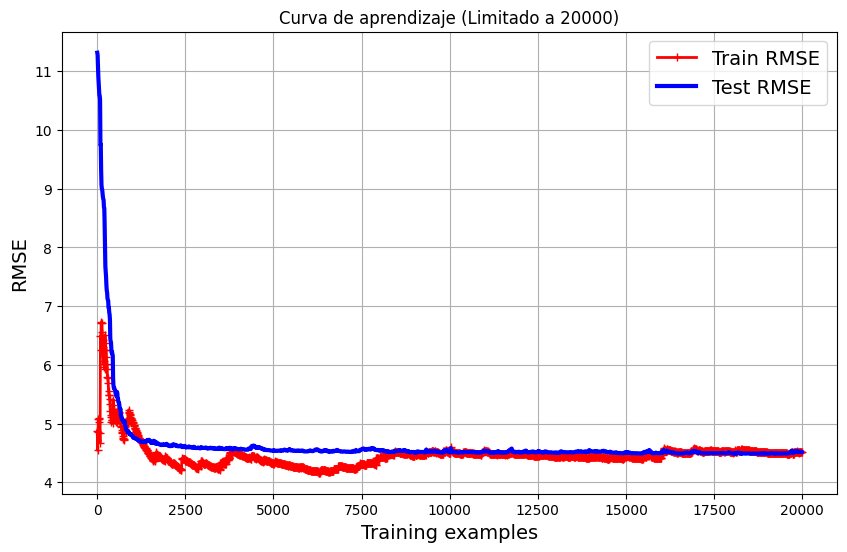

In [ ]:
# Inicializar listas para almacenar los errores
train_errors, test_errors = [], []
sample_rate = 10
max_samples = 5000  

# Crear modelo
sgd_model = SGDRegressor(max_iter=20000, tol=1e-3)
sgd_model.fit(X_train_scaled[:1], y_train[:1])

# Iterar hasta max_samples
for m in range(sample_rate, min(max_samples, len(X_train_scaled)) + 1, sample_rate):
    sgd_model.partial_fit(X_train_scaled[m-sample_rate:m], y_train[m-sample_rate:m])

    y_train_predict = sgd_model.predict(X_train_scaled[:m])
    y_test_predict = sgd_model.predict(X_test_scaled)

    train_rmse = np.sqrt(np.mean((y_train[:m] - y_train_predict) ** 2))
    test_rmse = np.sqrt(np.mean((y_test - y_test_predict) ** 2))

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_errors)*sample_rate, sample_rate), train_errors, "r-+", linewidth=2, label="Train RMSE")
plt.plot(range(0, len(test_errors)*sample_rate, sample_rate), test_errors, "b-", linewidth=3, label="Test RMSE")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Training examples", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Curva de aprendizaje (Limitado a 20000)")
plt.grid(True)
plt.show()

Podemos ver que la curva de entrenamiento presenta más ruido pero nos ayuda a converger más rápido. También podemos ver que por las épocas 5 mil a la 7 mil quinientos encontró un lote donde la métrica le dio mejor a lo que finalmente convergió. Pero esto puede ser debido al lote o cierta cantidad de lotes.

Podemos ver que las métricas a las que llegamos en los 3 modelos son muy parecidas, difieren de muy poco, lo que podemos decir que están llegando a mínimos muy parecidos, quizás mínimos locales pero no a un mínimo global. Podemos ver que seguimos teniendo los mismos coeficientes en donde ese 8,3 es el coeficiente que más aporta, el cual puede ser la distancia y tenemos coeficientes negativos que podría llegar a ser la hora del día (si es mañana o tarde). Suponiendo. Esto indica que los modelos se ajustan casi igual de bien y, además, en el gráfico de error vs. iteraciones, el valor en pocas iteraciones tiene el mismo valor que converge con el aumento de épocas, por lo que un gradiente descendente converge prácticamente al mismo resultado que el modelo de regresión.

# Regularizacion

In [ ]:
# Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)
coefficients_lasso = lasso_model.coef_
intercept_lasso = lasso_model.intercept_

# Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)
coefficients_ridge = ridge_model.coef_
intercept_ridge = ridge_model.intercept_

# Elastic Net
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_model.fit(X_train_scaled, y_train)
y_train_pred_elastic = elastic_model.predict(X_train_scaled)
y_test_pred_elastic = elastic_model.predict(X_test_scaled)
coefficients_elastic = elastic_model.coef_
intercept_elastic = elastic_model.intercept_

# Métricas
models = {
    "Lasso": (y_train_pred_lasso, y_test_pred_lasso, coefficients_lasso, intercept_lasso),
    "Ridge": (y_train_pred_ridge, y_test_pred_ridge, coefficients_ridge, intercept_ridge),
    "ElasticNet": (y_train_pred_elastic, y_test_pred_elastic, coefficients_elastic, intercept_elastic)
}

for name, (y_train_pred, y_test_pred, coefficients, intercept) in models.items():
    # Calcular manualmente el error cuadrático medio raíz (RMSE)
    train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
    test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

    # Calcular los valores R²
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{name} Model coefficients:", coefficients)
    print(f"{name} Model intercept:", intercept)
    print(f'{name} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'{name} - Train R2: {train_r2}, Test R2: {test_r2}')
    print("")


Lasso Model coefficients: [ 0.          8.17693044 -0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.        ]
Lasso Model intercept: 11.286986681500522
Lasso - Train RMSE: 4.472631174522478, Test RMSE: 4.453321648771169
Lasso - Train R2: 0.7739663737240562, Test R2: 0.7772738504179697

Ridge Model coefficients: [ 9.66776250e-02  8.27908050e+00 -2.62306647e-01 -7.35098725e-03
 -3.19947141e-02 -1.60528738e-02  1.77556154e-02  1.07286234e-02
  1.16907142e-02 -7.25176203e-01  1.03715032e+00  7.32668656e-01]
Ridge Model intercept: 10.258959304171869
Ridge - Train RMSE: 4.467685066539664, Test RMSE: 4.447101093309116
Ridge - Train R2: 0.7744660208046225, Test R2: 0.777895639200276

ElasticNet Model coefficients: [ 0.01173577  7.83519041 -0.01933086  0.         -0.          0.
  0.          0.          0.         -0.          0.          0.        ]
ElasticNet Model intercept: 11.27569114789012
ElasticNet - Train RMSE: 4.492893122630119, 

Podemos ver que Lasso eliminó casi todos los coeficientes y dejó solo el que aportaba más al precio positivamente y las métricas no cambiaron casi con los de los modelos anteriores.

Por otro lado Ridge no eliminó ninguna y sus métricas tampoco difieren de las demás, siguen siendo todas muy parecidas.

Por último tenemos ElasticNet que eliminó más de la mitad de los coeficientes, seguramente porque pusimos el l1_ratio=0.5, pero las métricas siguen siendo casi iguales a las demás.

# Optimizacion de parametros

In [ ]:
# Metric Function
def print_metrics(y_true, y_pred, dataset_type):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{dataset_type} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

In [ ]:
# Definición del modelo de regresión Stochastic Gradient Descent (SGD)
sgd = SGDRegressor()

# Grid de hiperparámetros para optimizar el modelo SGD
param_grid_sgd = {
    'alpha': np.logspace(-4, 2, num=10), # Probar con 100000
    'max_iter': [1000, 2000, 3000],  # Número máximo de iteraciones para el solver
    'tol': [1e-3, 1e-4, 1e-5]  # Tolerancia para los criterios de parada
}

# Configuración de GridSearchCV para encontrar los mejores hiperparámetros utilizando validación cruzada
grid_search_sgd = GridSearchCV(sgd, param_grid_sgd, cv=5, scoring='neg_mean_squared_error')

# Entrenamiento del modelo con el conjunto de datos de entrenamiento
grid_search_sgd.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros encontrados por GridSearchCV
print("Best hyperparameters for SGD:", grid_search_sgd.best_params_)

# Evaluación del modelo con los mejores hiperparámetros
best_sgd = grid_search_sgd.best_estimator_  # Obtener el mejor modelo
y_train_pred_best_sgd = best_sgd.predict(X_train_scaled)  # Predicciones en los datos de entrenamiento
y_test_pred_best_sgd = best_sgd.predict(X_test_scaled)  # Predicciones en los datos de prueba

# Imprimir métricas para el modelo SGD optimizado en los datos de entrenamiento
print_metrics(y_train, y_train_pred_best_sgd, 'Train (SGD Optimized)')

# Imprimir métricas para el modelo SGD optimizado en los datos de prueba
print_metrics(y_test, y_test_pred_best_sgd, 'Test (SGD Optimized)')

Best hyperparameters for SGD: {'alpha': np.float64(0.002154434690031882), 'max_iter': 3000, 'tol': 1e-05}
Train (SGD Optimized) - MSE: 19.98162163228889, RMSE: 4.470080718766596, MAE: 2.3730017649808843, R2: 0.7742240852917299
Test (SGD Optimized) - MSE: 19.783503064794086, RMSE: 4.447865000738454, MAE: 2.3810121973258305, R2: 0.7778193280302986


In [ ]:
# Definición del modelo de regresión Lasso
lasso = Lasso()

# Grid de hiperparámetros para la regresión Lasso usando una escala logarítmica
param_grid_lasso = {
    'alpha': np.logspace(-4, 2, num=10),
}

# Configuración de GridSearchCV para optimizar hiperparámetros utilizando validación cruzada
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')

# Entrenamiento del modelo con el conjunto de datos de entrenamiento
grid_search_lasso.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros encontrados por GridSearchCV
print("Best hyperparameters for Lasso:", grid_search_lasso.best_params_)

# Evaluación del modelo con los mejores hiperparámetros
best_lasso = grid_search_lasso.best_estimator_  # Obtener el mejor modelo
y_train_pred_best_lasso = best_lasso.predict(X_train_scaled)  # Predicciones en los datos de entrenamiento
y_test_pred_best_lasso = best_lasso.predict(X_test_scaled)  # Predicciones en los datos de prueba

# Imprimir métricas para el modelo Lasso optimizado en los datos de entrenamiento
print_metrics(y_train, y_train_pred_best_lasso, 'Train (Lasso Optimized)')

# Imprimir métricas para el modelo Lasso optimizado en los datos de prueba
print_metrics(y_test, y_test_pred_best_lasso, 'Test (Lasso Optimized)')


Best hyperparameters for Lasso: {'alpha': np.float64(0.0001)}
Train (Lasso Optimized) - MSE: 19.9602237572489, RMSE: 4.467686622542913, MAE: 2.351566240528258, R2: 0.7744658637068592
Test (Lasso Optimized) - MSE: 19.776600571321616, RMSE: 4.447088999707743, MAE: 2.3600551735573045, R2: 0.7778968471952795


In [ ]:
# Definición del modelo de regresión Ridge
ridge = Ridge()

# Grid de hiperparámetros para la regresión Ridge usando una escala logarítmica
param_grid_ridge = {
    'alpha': np.logspace(-4, 2, num=10),
}

# Configuración de GridSearchCV para encontrar los mejores hiperparámetros utilizando validación cruzada
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')

# Entrenamiento del modelo con el conjunto de datos de entrenamiento
grid_search_ridge.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros encontrados por GridSearchCV
print("Best hyperparameters for Ridge:", grid_search_ridge.best_params_)

# Evaluación del modelo con los mejores hiperparámetros
best_ridge = grid_search_ridge.best_estimator_  # Obtener el mejor modelo
y_train_pred_best_ridge = best_ridge.predict(X_train_scaled)  # Predicciones en los datos de entrenamiento
y_test_pred_best_ridge = best_ridge.predict(X_test_scaled) # Predicciones en los datos de prueba

# Imprimir métricas para el modelo Ridge optimizado en los datos de entrenamiento
print_metrics(y_train, y_train_pred_best_ridge, 'Train (Ridge Optimized)')

# Imprimir métricas para el modelo Ridge optimizado en los datos de prueba
print_metrics(y_test, y_test_pred_best_ridge, 'Test (Ridge Optimized)')



Best hyperparameters for Ridge: {'alpha': np.float64(4.641588833612772)}
Train (Ridge Optimized) - MSE: 19.96021071171582, RMSE: 4.467685162555193, MAE: 2.3516194804773445, R2: 0.7744660111106695
Test (Ridge Optimized) - MSE: 19.776716994253466, RMSE: 4.44710208947956, MAE: 2.3600973426533174, R2: 0.7778955396955336


Observamos que la optimización de los hiperparámetros no mostró cambios significativos con respecto a los resultados iniciales, tanto para el gradiente descendente como para Lasso y Ridge.

# Resultados y Conclusiones del Modelo

Los resultados muestran que la optimización de hiperparámetros no produjo cambios significativos en el rendimiento de los modelos (SGD, Lasso y Ridge).

 Mejores Hiperparámetros

-SGD
      **Hiperparámetros**: `{'alpha': np.float64(0.002154434690031882), 'max_iter': 3000, 'tol': 1e-05}`

      **Entrenamiento**:
        - MSE: 19.98162163228889
        - RMSE: 4.470080718766596
        - MAE: 2.3730017649808843
        - R²: 0.7742240852917299
      **Prueba**:
        - MSE: 19.783503064794086
        - RMSE: 4.447865000738454
        - MAE: 2.3810121973258305
        - R²: 0.7778193280302986

-Lasso
      **Hiperparámetros**: `{'alpha': np.float64(0.0001)}`

      **Entrenamiento**:
        - MSE: 19.9602237572489
        - RMSE: 4.467686622542913
        - MAE: 2.351566240528258
        - R²: 0.7744658637068592
      **Prueba**:
        - MSE: 19.776600571321616
        - RMSE: 4.447088999707743
        - MAE: 2.3600551735573045
        - R²: 0.7778968471952795

-Ridge
      **Hiperparámetros**: `{'alpha': np.float64(4.641588833612772)}`

      **Entrenamiento**:
        - MSE: 19.96021071171582
        - RMSE: 4.467685162555193
        - MAE: 2.3516194804773445
        - R²: 0.7744660111106695
      **Prueba**:
        - MSE: 19.776716994253466
        - RMSE: 4.44710208947956
        - MAE: 2.3600973426533174
        - R²: 0.7778955396955336


## Comparación de Modelos

Los 3 modelos son casi iguales pero el mejor es LassoCV mirando las métricas pero la diferencia de uno u otro modelo es imperceptible.
Ya que todos los modelos las métricas fueron muy parecidas podríamos decir que el modelo de regresión lineal fue uno de los mejores en tiempo de ejecución, también Lasso, Ridge y ElasticNet su tiempo fue muy bajo.

### Métricas de Rendimiento

1. **MSE**:
   - Los tres modelos muestran un MSE muy similar en el conjunto de prueba (~19.81).
   - No hay una diferencia significativa entre ellos en términos de este indicador.

2. **RMSE**:
   - Todos los modelos presentan un RMSE en prueba de aproximadamente 4.45.
   - Las diferencias son mínimas y prácticamente imperceptibles.

3. **MAE**:
   - El Error Absoluto Medio está alrededor de 2.36-2.38 para todos los modelos.
   - Lasso y Ridge muestran un MAE ligeramente menor (2.36) que SGD (2.38).

4. **R²**:
   - Todos los modelos explican aproximadamente el 78% de la varianza (R² ≈ 0.78).
   - No hay una diferencia práctica entre ellos en términos de capacidad explicativa.

---

## Conclusión

Los tres modelos (SGD, Lasso y Ridge) presentan rendimientos prácticamente idénticos después de la optimización de hiperparámetros. No hay uno que destaque significativamente sobre los demás en las métricas evaluadas.

## Análisis de la Curva de Aprendizaje

Basado en la curva de aprendizaje visualizada:

1. **Convergencia**: El modelo alcanza una estabilidad relativa después de aproximadamente 5,000 ejemplos de entrenamiento.

2. **Estabilidad**: Las curvas de error de entrenamiento y prueba convergen a valores similares (aproximadamente 4.5 RMSE), indicando que el modelo no sufre de sobreajuste ni subajuste significativo.

3. **Rendimiento**: Tanto el error de entrenamiento como de prueba se estabilizan, sugiriendo que añadir más datos más allá de 10,000 ejemplos no mejoraría significativamente el rendimiento.






Al haber hecho el análisis de las variables y las transformaciones y demás por ahí no estaría 100% seguro de los datos, siendo que no pudimos mejorar el rendimiento y disminuir el error, pudiendo que nuestra muestra no esté del todo bien realizada o que tenemos valores que muy probablemente son reales pero que al entrenarlo con esos valores nuestro modelo se nos puede llegar a aumentar la predicción y por ese caso aumenta el error de la predicción.